In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.optimize
import pandas.io.sql as psql
import pandas as pd
import sys
sys.path.insert(0,'C:\Users\Sean Violante\Documents\Projects\lendico\lib')
import dwh
from __future__ import division

In [5]:
%matplotlib qt

In [170]:
conn = dwh.get_DWH()


In [27]:
src_dir=r'C:\Users\Sean Violante\Documents\Projects\lendico\projects\returns\src'

In [ ]:
sql_strings=get_sql_strings(exclude_loans=False)

In [32]:
%cd  C:\Users\Sean Violante\Documents\Projects\lendico\projects\returns\src

C:\Users\Sean Violante\Documents\Projects\lendico\projects\returns\src


In [36]:
%run returns_sql.py
sql_strings=get_sql_strings(exclude_loans=False)
print sql_strings.keys()

['payment_plans_combined', 'loan_fundings_sql', 'payment_plans', 'actual_payments_combined', 'actual_payments', 'loans']


In [18]:
%time loans=psql.read_sql(loans_sql,conn)

Wall time: 10.8 s


In [42]:
arrears_dict={30:0.15,60:0.35, 90:0.67, 120:1,150:1,180:1,210:1,240:1,270:1}
arrears_dict={30:0.195, 60: 0.44, 90:0.611, 120:1,150:1,180:1,210:1,240:1,270:1}
arrears_dict={30:0.164, 60: 0.384, 90:0.55, 120:1,150:1,180:1,210:1,240:1,270:1}

In [615]:
loans.loc[loans.id_loan==330,['fk_ranking','date_of_first_loan_offer','base_date','rating','ranking_rating','pd','ranking_pd_start','ranking_pd_end','duration_months','base_return']]

,fk_ranking,date_of_first_loan_offer,base_date,rating,ranking_rating,pd,ranking_pd_start,ranking_pd_end,duration_months,base_return
347,261,2014-08-12,2014-07-01,C5,C5,5.41,5.41,6,60,0.0609


In [582]:
base_returns[base_returns.rating=='C2']

,date,rating,duration:6,duration:12,duration:24,duration:36,duration:48,duration:60
7,2013-11-01,C2,0.01000,0.01000,0.02000,0.02000,0.02000,0.02000
33,2014-07-01,C2,0.03900,0.04290,0.04870,0.05200,0.05400,0.05540
58,2014-10-22,C2,0.01635,0.01824,0.02087,0.02346,0.02653,0.03015


In [171]:
%time loan_fundings=psql.read_sql(loan_fundings_sql,conn)

Wall time: 59.9 s


In [ ]:
%time loan_fundings=psql.read_sql(loan_fundings_sql,conn)
%time payment_plans=psql.read_sql(payment_plans_sql,conn)
%time actual_payments=psql.read_sql(actual_payments_sql,conn)
%time actual_payments_combined=psql.read_sql(actual_payments_combined_sql,conn)

In [26]:
%time payment_plans_combined=psql.read_sql(payment_plans_combined_sql,conn)

Wall time: 36min 26s


In [29]:
payment_plans_combined.to_csv('C:\Users\Sean Violante\Documents\Projects\lendico\Projects\Returns\payout_plans_combined.txt')

In [83]:
actual_payments1=extend_actual_payments(actual_payments1,loans,arrears_dict)

In [173]:
loans.columns

Index([                 u'dwh_country_id',                         u'id_loan',
                       u'fk_loan_request',                         u'fk_user',
                            u'fk_ranking',                    u'country_name',
                         u'currency_code',      u'loan_request_creation_date',
                              u'user_age',                         u'loan_nr',
                                 u'title',                         u'purpose',
                   u'financial_situation',                     u'self_rating',
                                u'rating',                u'principal_amount',
                              u'duration',     u'nominal_interest_percentage',
             u'promo_interest_percentage',                      u'fee_amount',
                       u'interest_amount',                   u'total_payback',
                             u'is_active',                        u'category',
                    u'ranking_serialized',          

In [210]:
loans=extend_loans(loans)
loan_fundings=extend_loan_fundings(loan_fundings,loans)
actual_payments=extend_actual_payments(actual_payments, loans, arrears_dict)
actual_payments_combined=extend_actual_payments(actual_payments_combined, loans, arrears_dict)


In [255]:
%run returns.py

Note we are using payout date not originated since date

In [533]:
# in calculating irr need to add grouping variables. if keep principal, loan payments and principal repayment separate, then need to readd afterwards

In [ ]:
# find interval of latest date in actual payments
latest_paid_interval=actual_payments[['iso_date','fk_loan','interval']].sort('iso_date').groupby('fk_loan').interval.last()
latest_paid_interval.name='latest_paid_interval'
latest_paid_interval_investor=actual_payments_combined[['iso_date','fk_loan','fk_user_investor','interval']].sort('iso_date')\
    .groupby(['fk_loan','fk_user_investor']).interval.last()
latest_paid_interval_investor.name='latest_paid_interval'

In [177]:
cashflows_act_investor=generate_cashflows_act_investor(actual_payments_combined,loan_fundings1,'2015-04-30')

,date,fk_user_investor,id_loan,payment,dcf,rating_base,rating_switch,payback_state
75817,2014-09-30,25151,304,11.9300,0.501370,C,2,payback_pending
75818,2014-10-31,25151,304,50.5000,0.416438,C,2,payback_pending
75819,2014-11-30,25151,304,50.5000,0.334247,C,2,payback_pending
75820,2014-12-31,25151,304,0.0000,0.249315,C,2,payback_pending
75821,2015-01-31,25151,304,101.0000,0.164384,C,2,payback_pending
75822,2015-02-28,25151,304,50.5000,0.087671,C,2,payback_pending
75823,2015-03-31,25151,304,51.0200,0.002740,C,2,payback_pending
75824,2015-04-30,25151,304,51.0200,-0.079452,C,2,payback_pending
146717,2015-04-30,25151,304,2256.8057,-0.079452,C,2,payback_pending
172243,2014-08-08,25151,304,-2500.0000,0.646575,C,2,payback_pending


In [30]:
payment_plans.sort(['fk_loan','interval'],inplace=True) #prob unnecc? but need sorted for rebase

In [209]:
future_pd_30360_arrears=make_future_pd(payment_plans_combined, loans1, arrears_dict,True,'2015-04-30')
future_pd_30360_origpd=make_future_pd(payment_plans_combined, loans1, arrears_dict,False,'2015-04-30')
future_pd_30360_arrears_latest_paid=make_future_pd(payment_plans_combined, loans1, arrears_dict,True,'2015-04-30',latest_paid_interval_investor)
future_pd_30360_origpd_latest_paid=make_future_pd(payment_plans_combined, loans1, arrears_dict,False,'2015-04-30',latest_paid_interval_investor)
future_pd_30360_origpd_all=make_future_pd(payment_plans_combined, loans1, arrears_dict,False)

In [276]:
payback_complete_loans=loans.loc[loans.payback_state=='payback_complete','id_loan']
payback_complete_loans_latest=payment_plans[payment_plans.fk_loan.isin(payback_complete_loans)].groupby('fk_loan').interval_payback_date.max()

In [278]:
payback_complete_loans_latest.max()

datetime.date(2015, 5, 1)

In [47]:
actual_payments_combined.shape

(202798, 46)

In [249]:
EOM_dates=pd.date_range('2014-01-01', '2015-04-30', freq='M')
pd.DataFrame({'d':EOM_dates,'e':EOM_dates + pd.tseries.offsets.MonthEnd(-3)})

,d,e
0,2014-01-31,2013-10-31
1,2014-02-28,2013-11-30
2,2014-03-31,2013-12-31
3,2014-04-30,2014-01-31
4,2014-05-31,2014-02-28
5,2014-06-30,2014-03-31
6,2014-07-31,2014-04-30
7,2014-08-31,2014-05-31
8,2014-09-30,2014-06-30
9,2014-10-31,2014-07-31


In [56]:

#np.array(actual_payments_combined.iso_date.unique(),'datetime64[D]')
minimum_vintage=pd.tseries.offsets.MonthEnd(3)
EOM_dates-minimum_vintage

DatetimeIndex(['2013-10-31', '2013-11-30', '2013-12-31', '2014-01-31',
               '2014-02-28', '2014-03-31', '2014-04-30', '2014-05-31',
               '2014-06-30', '2014-07-31', '2014-08-31', '2014-09-30',
               '2014-10-31', '2014-11-30', '2014-12-31', '2015-01-31'],
              dtype='datetime64[ns]', freq='M', tz=None)

In [184]:
import itertools

In [256]:
reporting_dates=EOM_dates
loan_ids=loan_fundings
#irrs=pd.DataFrame({ 'irr': np.nan},index=[reporting_dates,)
dfs=[]                                          
for EOM_date in reporting_dates:
    loan_principals=loan_fundings.loc[loan_fundings.originated_since_date<=(EOM_date-minimum_vintage),
                        ['rating_base','fk_loan', 'fk_user_investor', 
                         'originated_since_date','originated_since_date_EOM','dcf','payment']]
    # loan payments may have payments for loans that have been filterd out by origination date but grouping filters it out
    loan_payments=actual_payments_combined.loc[actual_payments_combined.iso_date<=EOM_date.date(),
                    ['rating_base','fk_loan','fk_user_investor', 'originated_since_date','dcf','payment_amount_investor_month']]\
            .rename(columns={'payment_amount_investor_month':'payment'})
    residuals, recoveries=generate_residual_act_investor(actual_payments_combined, loan_fundings,\
                                                       EOM_date.date(), payment_plans=None)
    gps=[ zx.groupby(['fk_loan','dcf']).payment.sum().reset_index('dcf').groupby(level=0) \
             for zx in [loan_principals,loan_payments,residuals,recoveries] if zx is not None ]
    df=gps[0].apply(lambda x: xirr([x]+[z.get_group(x.index[0]) for z in gps[1:] if x.index[0] in z.groups.keys()]))
    dfs.append(df)
    
    #loan_payments=payments paid before EOM_date
    #loan_final_principal=remaining principal
# what about repayment
# what about end of loan
    #group by rating/date (to sum over investors)
    #generate IRR

In [257]:
df_all=pd.concat(dfs,keys=reporting_dates)
df_all.columns=['irr']
df_all.to_clipboard()


In [217]:
loans.loc[loans.fk_loan==95].originated_since_date

87   2014-03-28
Name: originated_since_date, dtype: datetime64[ns]

In [218]:
loan_principals.fk_loan.unique()

array([ 8,  4,  3,  6,  9, 14, 20, 18, 12, 13, 15, 11,  7, 16, 10, 17, 21,
       19, 26, 28, 27, 23, 24, 30, 22, 34, 29, 33, 32, 35, 37, 31, 36, 46,
       41, 44, 38, 43, 57, 40, 42, 45, 49, 47, 54, 59, 63, 56, 51, 50, 48,
       65, 61, 53, 55, 81, 58, 74, 67, 64, 60, 69, 76, 68, 72, 77, 71, 80,
       73, 62, 70, 66, 75, 87, 83, 89, 93, 85, 82, 84, 88, 92, 86, 96, 91,
       95, 98, 97], dtype=int64)

In [231]:
df_all.to_clipboard()

In [114]:
(EOM_date-minimum_vintage).date()

datetime.date(2013, 10, 31)

In [163]:
xirr([loan_principals[loan_principals.fk_loan==loan_test],
      loan_payments[loan_payments.fk_loan==loan_test],residuals[residuals.fk_loan==loan_test],recoveries[recoveries.fk_loan==loan_test]])

0.031639427173267932

In [234]:
loan_test=10

In [248]:
EOM_date

Timestamp('2014-05-30 00:00:00', offset='BM')

In [251]:
z=loan_payments
z[z.fk_loan==loan_test].groupby(['dcf']).payment.sum()

dcf
0.835616    225.29
0.920548    450.58
1.002740      0.00
1.087671    225.29
1.164384      0.00
Name: payment, dtype: float64

In [244]:
actual_payments.loc[actual_payments.fk_loan==loan_test,['iso_date','actual_amount_month']]

,iso_date,actual_amount_month
32,2014-01-31,0.79
33,2014-02-28,220.91
34,2014-03-31,0.00
35,2014-04-30,445.05
36,2014-05-31,220.91
37,2014-06-30,220.91
38,2014-07-31,220.91
39,2014-08-31,220.91
40,2014-09-30,220.91
41,2014-10-31,220.91


In [241]:
actual_payments.columns

Index([              u'dwh_country_id',             u'fk_user_borrower',
                            u'fk_loan',                      u'loan_nr',
                           u'iso_date',                     u'interval',
              u'interval_payback_date',               u'payment_amount',
                 u'payment_amount_cum',             u'principal_amount',
                    u'interest_amount', u'sum_interval_interest_amount',
                u'interest_amount_cum',     u'residual_interest_amount',
               u'principal_amount_cum',     u'initial_principal_amount',
          u'residual_principal_amount',        u'expected_amount_month',
                u'expected_amount_cum',          u'actual_amount_month',
                  u'actual_amount_cum',              u'in_arrears_flag',
                   u'in_arrears_since',        u'in_arrears_since_days',
                                u'dcf',  u'in_arrears_since_days_30360',
                             u'bucket',            

In [157]:
loan_payments.head()

,rating_base,fk_loan,originated_since_date,dcf,payment
0,C,7,NaN,1.164384,0
1,C,7,NaN,1.164384,0
2,C,7,NaN,1.164384,0
3,C,7,NaN,1.164384,0
4,C,7,NaN,1.164384,0


In [ ]:
recoveries

In [147]:
loan_principals.fk_loan.head()

0    8
1    8
2    8
3    8
4    8
Name: fk_loan, dtype: int64

In [146]:
EOM_date

Timestamp('2015-04-30 00:00:00', offset='BM')

In [177]:
irrs

,irr
2014-01-31,-1.000000
2014-02-28,-1.000000
2014-03-31,-1.000000
2014-04-30,NaN
2014-05-30,-1.000000
2014-06-30,NaN
2014-07-31,NaN
2014-08-29,NaN
2014-09-30,NaN
2014-10-31,NaN


In [139]:
%debug

> c:\anaconda\lib\site-packages\pandas\core\generic.py(2083)__getattr__()
   2082             raise AttributeError("'%s' object has no attribute '%s'" %
-> 2083                                  (type(self).__name__, name))
   2084 

ipdb> u
> c:\users\sean violante\documents\projects\lendico\projects\returns\src\returns.py(47)xnpv()
     46         else:
---> 47             dcfs = amount_dcf_or_list.dcf
     48             amounts = amount_dcf_or_list.payment

ipdb> amount_dcf_or_list.columns
Index([u'rating_base', u'fk_loan', u'originated_since_date',
       u'originated_since_date_EOM', u'payment'],
      dtype='object')
ipdb> q


In [68]:
loan_principals

,rating_base,originated_since_date,originated_since_date_EOM,payment
272,C,2013-12-27,2014-01-25,-300
273,C,2013-12-27,2014-01-25,-300
274,C,2013-12-27,2014-01-25,-75
275,C,2013-12-27,2014-01-25,-50
276,C,2013-12-27,2014-01-25,-25
277,C,2013-12-27,2014-01-25,-25
278,C,2013-12-27,2014-01-25,-50
279,C,2013-12-27,2014-01-25,-50
280,C,2013-12-27,2014-01-25,-25
281,C,2013-12-27,2014-01-25,-100


In [281]:
((loans.originated_since_date<datetime.date(2015,2,28)) & (loans.payback_state=='payback_complete')).sum()

59

In [282]:
((loans.originated_since_date<datetime.date(2015,2,28))).sum()

1256

In [618]:
future_pd_30360_origpd_all[(future_pd_30360_origpd_all.fk_loan==330) & (future_pd_30360_origpd_all.fk_user_investor==63)].to_clipboard()

In [686]:
cashflows_act_investor_20150430_def=generate_cashflows_act_investor(actual_payments_combined,loan_fundings1,'2015-04-30',payment_plans_combined)

In [644]:
defs=actual_payments_combined.loc[(actual_payments_combined.iso_date==datetime.date(2015,4,30))& (actual_payments_combined.in_arrears_since_days_30360>90),['fk_loan','iso_date','in_arrears_since_days_30360']].fk_loan.unique()
defs

array([ 27,  76,  85,  88, 299, 355, 362, 439, 449, 675], dtype=int64)

In [687]:
z=actual_payments_combined
z[(z.fk_loan==85) & (z.fk_user_investor==9614)].to_clipboard()

,dwh_country_id,fk_user_borrower,fk_user_investor,fk_loan,loan_request_nr,iso_date,nominal_interest_percentage,promo_interest_percentage,has_promo_flag,is_repaid_flag,...,residual_principal_amount_investor,expected_amount_month,expected_amount_cum,actual_amount_month,actual_amount_cum,in_arrears_flag,in_arrears_since,in_arrears_since_days,in_arrears_since_days_30360,cum_diff
18729,1,9384,9614,85,68722247,2014-04-30,4.03,3,1,NaN,...,50.0000,10.07,10.07,10.07,10.07,0,None,NaN,NaN,0.00
18738,1,9384,9614,85,68722247,2014-05-31,4.03,3,1,NaN,...,49.2951,92.16,102.23,92.16,102.23,0,None,NaN,NaN,0.00
18757,1,9384,9614,85,68722247,2014-06-30,4.03,3,1,NaN,...,48.5863,92.16,194.39,92.16,194.39,0,None,NaN,NaN,0.00
18773,1,9384,9614,85,68722247,2014-07-31,4.03,3,1,NaN,...,47.8736,92.16,286.55,92.16,286.55,0,None,NaN,NaN,0.00
18782,1,9384,9614,85,68722247,2014-08-31,4.03,3,1,NaN,...,47.1570,92.16,378.71,92.16,378.71,0,None,NaN,NaN,0.00
18810,1,9384,9614,85,68722247,2014-09-30,4.03,3,1,NaN,...,46.4365,92.16,470.87,92.16,470.87,0,None,NaN,NaN,0.00
18815,1,9384,9614,85,68722247,2014-10-31,4.03,3,1,NaN,...,45.7120,92.16,563.03,92.16,563.03,0,None,NaN,NaN,0.00
18839,1,9384,9614,85,68722247,2014-11-30,4.03,3,1,NaN,...,44.9835,92.16,655.19,92.16,655.19,0,None,NaN,NaN,0.00
18842,1,9384,9614,85,68722247,2014-12-31,4.03,3,1,NaN,...,44.2510,92.16,747.35,95.16,750.35,0,None,NaN,NaN,-3.00
18870,1,9384,9614,85,68722247,2015-01-31,4.03,3,1,NaN,...,44.2510,92.16,839.51,0.00,750.35,1,2015-01-01,30,30,89.16


In [654]:
cashflows_act_investor_20150430[(cashflows_act_investor_20150430.id_loan==27) & (cashflows_act_investor_20150430.fk_user_investor==2190)].to_clipboard()

In [ ]:
z=cashflows_act_investor_20150430_def
z[(z.id_loan==85) & (z.fk_user_investor==9614)].to_clipboard()

In [658]:
cashflows_act_investor_20150430_def=add_loan_rating(cashflows_act_investor_20150430_def,loans1)

In [691]:
z=loan_fundings1
z[(z.fk_loan==3) & (z.fk_user==38)]

,dwh_country_id,id_loan_funding,fk_loan,fk_loan_request,fk_user,country_name,currency_code,loan_request_creation_date,amount,investment_yield,...,created_at,updated_at,dwh_created,dwh_last_modified,id_loan,originated_since_date,originated_since_date_EOM,payback_day,principal_amount,loan_coverage1
13,1,652,3,10,38,Germany,EUR,2013-11-30,800,4.7033,...,2013-12-09 11:53:09,2015-05-14 09:16:07,2014-02-21 17:33:03.857077,2015-05-14 10:21:02.718089,3,2014-01-10,2014-01-25,15,3800,21.052632


For actual - to EOM valuation date, we use principal outstanding (ie including in arrears principal)
For actual_origpd/arrears - using future cashflows we take future cashflows (ie after EOM date) rather than last paid principal

In [542]:
cashflows_act_investor_20150430=generate_cashflows_act_investor(actual_payments_combined,loan_fundings1,'2015-04-30',payment_plans_combined)
cashflows_act_arrears_investor=generate_cashflows(future_pd_30360_arrears,loan_fundings1,True,'2015-04-30',  actual_payments_combined)
cashflows_act_origpd_investor=generate_cashflows(future_pd_30360_origpd,loan_fundings1,True,'2015-04-30', actual_payments_combined)

cashflows_act_arrears_latest_paid_investor=generate_cashflows(future_pd_30360_arrears_latest_paid,loan_fundings1,True,'2015-04-30',  actual_payments_combined)
cashflows_act_origpd_latest_paid_investor=generate_cashflows(future_pd_30360_origpd_latest_paid,loan_fundings1,True,'2015-04-30', actual_payments_combined)



In [543]:
cashflows_plan_origpd_all=generate_cashflows(future_pd_30360_origpd_all,loan_fundings1,True)
cashflows_plan_origpd_noshift_all=generate_cashflows(future_pd_30360_origpd_all,loan_fundings1,False)


In [544]:
cashflows_plan_investor_20150430=generate_cashflows_pp(payment_plans_combined,loan_fundings1,loans,'2015-04-30')
cashflows_plan_investor_all=generate_cashflows_pp(payment_plans_combined,loan_fundings1,loans)

In [545]:
def replace_repaid(actual_cashflows,plan_cashflows):
    return pd.concat([actual_cashflows[actual_cashflows.payback_state!='payback_complete'],
                      plan_cashflows[plan_cashflows.payback_state=='payback_complete']],ignore_index=True)

In [546]:
cashflows_act_investor_20150430_repaid = replace_repaid(cashflows_act_investor_20150430,cashflows_plan_investor_all)
cashflows_act_arrears_latest_paid_investor_repaid = replace_repaid( cashflows_act_arrears_latest_paid_investor,cashflows_plan_investor_all)
cashflows_act_origpd_latest_paid_investor_repaid = replace_repaid( cashflows_act_origpd_latest_paid_investor,cashflows_plan_investor_all)


In [275]:
payment_plans_combined[(payment_plans_combined.fk_loan==34) & (payment_plans_combined.fk_user_investor==38)].to_clipboard()

In [273]:
cashflows_act_investor_EOM[(cashflows_act_investor_EOM.id_loan==34) & (cashflows_act_investor_EOM.fk_user_investor==38)].to_clipboard()

In [255]:
cashflows_plan_origpd_noshift_all[(cashflows_plan_origpd_noshift_all.id_loan==574) & (cashflows_plan_origpd_noshift_all.fk_user_investor==31192)].to_clipboard()

In [256]:
future_pd_30360_origpd_all[(future_pd_30360_origpd_all.fk_loan==574) & (future_pd_30360_origpd_all.fk_user_investor==31192)].to_clipboard()

In [38]:
loans_act_xirr=cashflows_act_investor.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

NameError: name 'cashflows_act_investor' is not defined

In [560]:
loans_act_arrears_latest_paid_xirr=cashflows_act_arrears_latest_paid_investor.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))
loans_act_origpd_latest_paid_xirr=cashflows_act_origpd_latest_paid_investor.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [559]:
loans_act_arrears_latest_paid_repaid_xirr=cashflows_act_arrears_latest_paid_investor_repaid.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))
loans_act_origpd_latest_paid__repaid_xirr=cashflows_act_origpd_latest_paid_investor_repaid.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [151]:
cashflows_act_arrears_investor[(cashflows_act_arrears_investor.id_loan==675) & (cashflows_act_arrears_investor.fk_user_investor==38)].to_clipboard()

In [548]:
loans_act_20150430_xirr=cashflows_act_investor_20150430.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [549]:
loans_act_20150430_repaid_xirr=cashflows_act_investor_20150430_repaid.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [552]:
loans_act_arrears_xirr=cashflows_act_arrears_investor.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [551]:
loans_act_origpd_xirr=cashflows_act_origpd_investor.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [553]:
loans_plan_origpd_xirr=cashflows_plan_origpd_all.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [555]:
loans_plan_origpd_noshift_xirr=cashflows_plan_origpd_noshift_all.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [557]:
loans_plan_20150430_xirr=cashflows_plan_investor_20150430.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [242]:
loans_plan_origpd_xirr[350]

0.084111226975740833

In [249]:
cashflows_plan_origpd_noshift_all[(cashflows_plan_origpd_noshift_all.id_loan==210)&(cashflows_plan_origpd_noshift_all.fk_user_investor==25151)].to_clipboard()

In [558]:
loans_plan_all_xirr=cashflows_plan_investor_all.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

plan_all: assumes all payments were made according to plan


act_EOM: uses actual payments until reporting date, and assumes outstanding principal repaid


act_origpd:: uses actual payments until reporting date, and predicts payments for subsequent dates (so missing payments will never be paid back)


act_origpd_latest_paid:: uses actual payments until reporting date, and predicts payments for remaining loan ( including currently in arrears)


act_arrears - same but with inarrears pd

In [195]:
cashflows_plan_investor_20150430.head()

,id_loan,fk_user_investor,date,payment,dcf,originated_since_date,rating_base,rating_switch,payback_state
0,3,38,2014-02-15,34.99,1.123288,2014-01-10,C,1,payback_received
1,3,38,2014-03-15,34.99,1.046575,2014-01-10,C,1,payback_received
2,3,38,2014-04-15,34.99,0.961644,2014-01-10,C,1,payback_received
3,3,38,2014-05-15,34.99,0.879452,2014-01-10,C,1,payback_received
4,3,38,2014-06-15,34.99,0.794521,2014-01-10,C,1,payback_received


In [ ]:
loans.date_of_first_loan_offer

In [587]:
#loans_xirr=pd.DataFrame({'plan':loan_pp_xirr,'origpd':loans_fut_xirr_origpd, 'inarr':loans_fut_xirr_arrears})
loans_xirr=pd.DataFrame({'plan_all':loans_plan_all_xirr,\
                         'plan_20150430':loans_plan_20150430_xirr,\
                         'act_20150430':loans_act_20150430_xirr,
                         'act_20150430_repaid':loans_act_20150430_repaid_xirr,
                         'act_origpd':loans_act_origpd_xirr, 
                         'act_arrears' :loans_act_arrears_xirr,
                         'act_origpd_latest_paid':loans_act_origpd_latest_paid_xirr, 
                         'act_origpd_latest_paid_repaid':loans_act_origpd_latest_paid__repaid_xirr, 
                         'act_arrears_latest_paid' :loans_act_arrears_latest_paid_xirr,
                         'act_arrears_latest_paid_repaid' :loans_act_arrears_latest_paid_repaid_xirr,
                        'plan_origpd': loans_plan_origpd_xirr, 
                         'plan_origpd_noshift': loans_plan_origpd_noshift_xirr 
                        })
loans_xirr=loans_xirr.merge(loans1[['id_loan','date_of_first_loan_offer','originated_since_date','principal_amount','payback_state','pd','bucket_pd',
                                    'rating','base_date', 'base_return']],\
                            left_index=True,right_on='id_loan')
loans_xirr['orig_month']=np.array(loans_xirr.originated_since_date,'datetime64[M]')
loans_xirr['rating_base']=loans_xirr['rating'].str[0]

loans_xirr=loans_xirr.reindex(columns=['id_loan','date_of_first_loan_offer','originated_since_date','orig_month','principal_amount','payback_state',\
                                       'pd','bucket_pd','rating','rating_base','base_date','base_return', 'plan_all','plan_20150430',\
                                       'act_20150430','act_20150430_repaid', 'plan_origpd_noshift','plan_origpd', \
                                      'act_origpd', 'act_arrears', \
                                      'act_origpd_latest_paid','act_origpd_latest_paid_repaid', \
                                       'act_arrears_latest_paid', 'act_arrears_latest_paid_repaid'
                                      ])
loans_xirr=abs_diff(loans_xirr,[('base_return','plan_origpd_noshift'),
                                ('plan_origpd_noshift', 'plan_origpd'),
                                ('plan_20150430','act_20150430'),
                                ('act_20150430','act_arrears_latest_paid_repaid')])
                                
                                
loans_xirr.to_clipboard(index=False)

In [268]:
loans_xirr[loans_xirr.bucket_pd.notnull()].head()

,id_loan,originated_since_date,orig_month,principal_amount,payback_state,pd,bucket_pd,rating,rating_base,rating_switch,plan_all,plan_20150430,act_EOM,plan_origpd_noshift,plan_origpd,act_origpd,act_arrears,act_origpd_latest_paid,act_arrears_latest_paid
20,27,2014-01-20,2014-01-01,5000,payback_complete,1.80,1.000,A3,A,1,0.047859,0.047859,-0.885755,0.040468,0.042525,-0.885755,-0.885755,0.041265,-0.281649
25,34,2014-01-29,2014-01-01,8000,payback_received,10.25,0.164,E4,E,1,0.146789,0.143436,0.121602,0.069296,0.070657,0.099493,0.075065,0.107446,0.081820
29,35,2014-01-29,2014-01-01,5000,payback,5.07,0.164,C2,C,1,0.079247,0.079233,0.025790,0.055918,0.060880,0.032465,0.021970,0.076651,0.064536
35,44,2014-02-10,2014-02-01,5000,payback,10.25,0.164,E4,E,1,0.143996,0.139811,0.112054,0.093955,0.098556,0.107971,0.092042,0.121196,0.104660
49,50,2014-02-13,2014-02-01,3000,payback,6.96,0.384,D2,D,1,0.110940,0.108226,0.054122,0.078254,0.081898,0.069243,-0.013235,0.093805,0.005128


In [225]:
loans_xirr[loans_xirr.id_loan==350]

,id_loan,originated_since_date,orig_month,principal_amount,payback_state,pd,bucket_pd,rating,rating_base,rating_switch,plan_all,plan_20150430,act_EOM,plan_origpd,act_origpd,act_arrears,act_origpd_latest_paid,act_arrears_latest_paid
360,350,2014-09-02,2014-09-01,6500,payback,6.98,NaN,D2,D,2,0.123274,0.124471,0.124442,0.084111,0.101725,0.101725,0.101725,0.101725


In [222]:
future_pd_30360_origpd_all[(future_pd_30360_origpd_all.id_loan==350)& (future_pd_30360_origpd_all.fk_user_investor==88)].to_clipboard()

In [207]:
loan_fundings1[(loan_fundings1.fk_loan==350)&(loan_fundings1.fk_user==88)].investment_yield

8554    11.5504
Name: investment_yield, dtype: float64

In [ ]:
cashflow

In [590]:

rating_switch_plan_all_xirr=gen_rating(cashflows_plan_investor_all, '2015-01-31',[3,4,6,8,11,14])
rating_switch_plan_origpd_xirr=gen_rating(cashflows_plan_origpd_all, '2015-01-31', [3,4,6,8,11,14])
rating_switch_plan_20150430_xirr=gen_rating(cashflows_plan_investor_20150430, '2015-01-31', [3,4,6,8,11,14])
rating_switch_act_20150430_repaid_xirr=gen_rating(cashflows_act_investor_20150430_repaid, '2015-01-31', [3,4,6,8,11,14])
rating_switch_act_arrears_latest_paid_investor_repaid=gen_rating(cashflows_act_arrears_latest_paid_investor_repaid, '2015-01-31', [3,4,6,8,11,14])
rating_switch_act_origpd_latest_paid_investor_repaid=gen_rating(cashflows_act_origpd_latest_paid_investor_repaid, '2015-01-31', [3,4,6,8,11,14])
#rating_switch_act_xirr=gen_rating(cashflows_act_investor, '2015-02-28', [3,4,6,8,11,14])



In [594]:
arrears_dict

{30: 0.164,
 60: 0.384,
 90: 0.55,
 120: 1,
 150: 1,
 180: 1,
 210: 1,
 240: 1,
 270: 1}

In [592]:
rating_switch_xirr=pd.DataFrame({'plan_all':rating_switch_plan_all_xirr,\
                                'plan_20150430':rating_switch_plan_20150430_xirr,\
                                'plan_origpd':rating_switch_plan_origpd_xirr,\
                                'act_20150430_repaid':rating_switch_act_20150430_repaid_xirr,\
                                'act_arrears_latest_paid_repaid':rating_switch_act_arrears_latest_paid_investor_repaid})
rating_switch_xirr.to_clipboard()
rating_switch_xirr
                                

act_20150430_repaid  act_arrears_latest_paid_repaid  \
base_date  rating_base                                                        
2013-11-01 A                       0.046398                        0.042966   
           B                       0.045773                        0.024875   
           C                       0.068110                        0.049172   
           D                       0.107901                        0.074283   
           E                       0.129219                        0.096206   
2014-07-01 A                       0.031691                        0.029720   
           B                       0.045688                        0.035422   
           C                       0.080639                        0.050308   
           D                       0.092931                        0.056388   
           E                       0.119488                        0.090670   
2014-10-22 A                       0.030765                        0.026226   
           B                       0.038895                        0.026691   
           C                       0.061009                        0.034710   
           D                       0.075147                        0.034469   
           E                       0.103581                        0.041727   

                        plan_20150430  plan_all  plan_origpd  
base_date  rating_base                                        
2013-11-01 A                 0.047052  0.047663     0.039846  
           B                 0.054704  0.055155     0.035750  
           C                 0.073975  0.073915     0.042027  
           D                 0.112281  0.113947     0.065641  
           E                 0.135040  0.135587     0.069020  
2014-07-01 A                 0.031697  0.033768     0.028535  
           B                 0.047638  0.049327     0.036157  
           C                 0.092414  0.093909     0.062524  
           D                 0.128877  0.130993     0.076537  
           E                 0.131330  0.133426     0.081157  
2014-10-22 A                 0.031646  0.032112     0.026758  
           B                 0.042316  0.043121     0.029963  
           C                 0.064779  0.065044     0.035143  
           D                 0.095902  0.097162     0.041952  
           E                 0.128717  0.131338     0.049799

In [122]:
cnt,bns=np.histogram(investor_fut_bucket_30360_xirr_orig, bins=np.linspace(-.5,.5,101))
a=pd.DataFrame({'bin':bns[:-1], 'count':cnt})
a.to_clipboard()
a

,bin,count
0,-0.50,0
1,-0.49,0
2,-0.48,0
3,-0.47,0
4,-0.46,0
5,-0.45,0
6,-0.44,0
7,-0.43,0
8,-0.42,0
9,-0.41,0


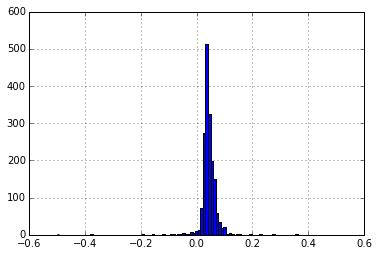

In [187]:
investor_fut_bucket_30360_xirr_orig.hist(bins=np.linspace(-.5,.5,110))

In [205]:
inv_count,inv_bin=np.histogram(investor_fut_bucket_30360_xirr_orig,bins=np.linspace(-.5,.5,101))


In [240]:
cashflows_act_investor[cashflows_act_investor.id_loan==1545]

,date,fk_user_investor,id_loan,payment,dcf,rating_base,rating_switch,payback_state
139859,2015-04-30,34180,1545,13.14,-0.079452,E,3,payback_received
164594,2015-04-30,34180,1545,5000.00,-0.079452,E,3,payback_received
192195,2015-04-07,34180,1545,-5000.00,-0.016438,E,3,payback_received


In [207]:
inv_hist=pd.DataFrame({'bin':inv_bin[:-1],'count':inv_count})

In [208]:
inv_hist.to_clipboard()

In [43]:
%matplotlib inline

In [154]:
loans_fut_bucket_30360_xirr_orig*100

rating_switch
1                2.446569
2                3.991386
3                3.453717
dtype: float64

In [165]:
loans_fut_bucket_30360_xirr_orig*100 

rating_switch
1                2.915440
2                4.099140
3                3.495064
dtype: float64

In [47]:
z1=cashflows_fut_bucket_30360[cashflows_fut_bucket_30360.payback_state!='payback_complete']

xirr(z1.payment, z1.dcf)

0.03470183916784976

In [42]:
loans_fut_bucket_30360_xirr_groups*100

rating_switch  rating_base
1              A              2.164635
               B             -0.289620
               C              2.843701
               D              4.380164
               E              7.495481
2              A              2.336687
               B              3.229219
               C              4.145394
               D              5.631069
               E              7.443198
3              A              2.390730
               B              2.876238
               C              3.830051
               D              4.275146
               E              4.906416
dtype: float64

In [43]:
loans_fut_bucket_30360_xirr_groups.to_clipboard()

In [308]:
loans_fut_bucket_30360_xirr_groups*100

rating_switch  rating_base
1              A              1.643829
               B             -0.131926
               C              2.983228
               D              4.437063
               E              7.266957
2              A              1.954274
               B              2.373271
               C              4.145764
               D              5.446206
               E              7.389547
3              A              2.368428
               B              2.950076
               C              3.790125
               D              3.940688
               E              4.880346
dtype: float64

In [167]:
loans_fut_xirr_groups=cashflows_fut[cashflows_fut.payback_state!='payback_complete'].groupby(['base_date','rating_base']).apply(lambda x: xirr(x.payment,x.dcf))

In [246]:
loans_fut_xirr_groups*100

rating_switch  rating_base
1              A               2.318630
               B               2.276984
               C               3.590574
               D               5.797576
               E               7.664678
2              A               2.533089
               B               3.506267
               C               6.085838
               D               7.710767
               E               7.674173
3              A             -15.986781
               B             -15.818247
               C             -14.123845
               D             -11.749378
               E             -12.484912
dtype: float64

In [309]:
(loans_fut_bucket_xirr_groups*100)

rating_switch  rating_base
1              A              1.643829
               B             -0.131926
               C              2.983228
               D              4.437063
               E              7.266957
2              A              1.954274
               B              2.373271
               C              4.145764
               D              5.446206
               E              7.389547
3              A              2.368428
               B              2.950076
               C              3.790125
               D              3.940688
               E              4.880346
dtype: float64

In [100]:
miss_loans=set(loans.id_loan) ^ set(payment_plans.fk_loan) # symmetric difference

In [251]:
(loans_xirr.loc[mth3_loans]*100).hist()

In [39]:
irreg_payments_sql="select * from backend.loan_payment_plan where plan ~* 'IRREGULAR' and dwh_country_id=1"
# problem with like '%irregular%#
irreg_payments=psql.read_sql_query(irreg_payments_sql,conn)
irreg_payments.columns
cols=irreg_payments.columns.values.tolist()
cols.remove('plan')
cols
li=[]
cols=irreg_payments.columns.values.tolist()
cols.remove('plan')

for i in range(irreg_payments.shape[0]):
    z=pd.read_json(irreg_payments.plan[i])
    for c in cols:
        z.loc[:,c]=irreg_payments.iloc[i][c]
    li.append(z)

irreg_p=pd.concat(li)


In [40]:
z1=pd.DataFrame(actual_payments.set_index(['iso_date','fk_loan'])[['in_arrears_since', 'in_arrears_since_days']])
z1['bucket']=np.ceil(z1.in_arrears_since_days/30)
a1=z1.bucket.unstack()

a2=a1.shift(-1, freq='M')
a3=a1.shift(-2, freq='M')
a4=a1.shift(-3, freq='M')
a5=a1.shift(-4, freq='M')
a6=a1.shift(-5, freq='M')
a7=a1.shift(-6, freq='M')


z1['in_arrears_since_1M']=a2.stack()
z1['in_arrears_since_2M']=a3.stack()
z1['in_arrears_since_3M']=a4.stack()
z1['in_arrears_since_4M']=a5.stack()
z1['in_arrears_since_5M']=a6.stack()
z1['in_arrears_since_6M']=a7.stack()
# trying to detemine stability 
z2=z1.fillna(0)
z3=z2.groupby(['bucket','in_arrears_since_1M']).size()

In [599]:
loans.loan_nr[loans.id_loan==815]

471    547197732
Name: loan_nr, dtype: int64

In [107]:
loan_plan_nar=payment_plans_idx.loc[payment_plans_idx.interval!=0,['interest_amount','initial_principal_amount']].groupby(level=(0,1)).sum()